In [1]:
import pandas as pd
import numpy as np
import pickle
import scipy.constants as phy_const
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import os
import glob
import sys
import configparser

import MakePlots_Charoy as mplt_mod
import FLHET_compiled
from modules.simu_params import SimuParameters


# Extraction of the fluid results

In [57]:
fluid_dir   = "./Results/charoy_checkcase_0_N400_no_hflux_no_coll"

unvariant_data_file     = fluid_dir + "/Data/MacroscopicUnvariants.pkl"
steady_stat_file        = fluid_dir + "/Data/MacroscopicVars_000062.pkl"

with open(unvariant_data_file, 'rb') as f:
    [Barr, x_mesh, x_center, alpha_B] = pickle.load(f)
with open(steady_stat_file, 'rb') as f:
    [t, P, U, P_Inlet, P_Outlet, J, Efield] = pickle.load(f)

msp     = SimuParameters(fluid_dir + "/Configuration.cfg")

LTHR    = msp.LTHR
ESTAR   = msp.ESTAR
wall_inter_type     = msp.wall_inter_type
R1  = msp.R1
R2  = msp.R2
Mi  = msp.Mi
KEL = msp.KEL

NBPOINTS = np.shape(x_center)[0]

FileNotFoundError: [Errno 2] No such file or directory: './Results/charoy_checkcase_0_N400_no_hflux_no_coll/Data/MacroscopicUnvariants.pkl'

# Plot variables

In [7]:
tickfontsize    = 15
legendfontsize  = 18
axisfontsize    = 18
titlefontsize   = 20

# Comparison with the PIC data from F.P. comparison of $R_{ei}$  and energy terms

In [ ]:
extracted_df = pd.read_csv("./Inputs/20240709_PIC_data_FP/20240709_PIC_ext_df.csv", sep="\t", header=0)
print(extracted_df.columns)

Index(['Unnamed: 0', 'x', 'EE', 'n_e', 'corr_term', 've_y', 've_x', 'Te_x',
       'Te_y', 'BB', 'dEy_2', 'dJy_dEy'],
      dtype='object')


## Comparison of force density terms

In [ ]:
Rei_emp_arr     = mplt_mod.compute_Rei_empirical(P, Barr, ESTAR, wall_inter_type, R1, R2, Mi, x_center, LTHR, KEL, alpha_B)
Rei_sat_arr     = mplt_mod.compute_Rei_saturated(P, Mi, x_center)
magnetic_term   = - phy_const.e * P[1, :] * Barr * P[4, :]

Plot have proved that magnetic_term = Rei_emp_arr. That is logic since in the fluid code we ignored all other terms in the momentum $e^-$ equation along the azimuthal axis.

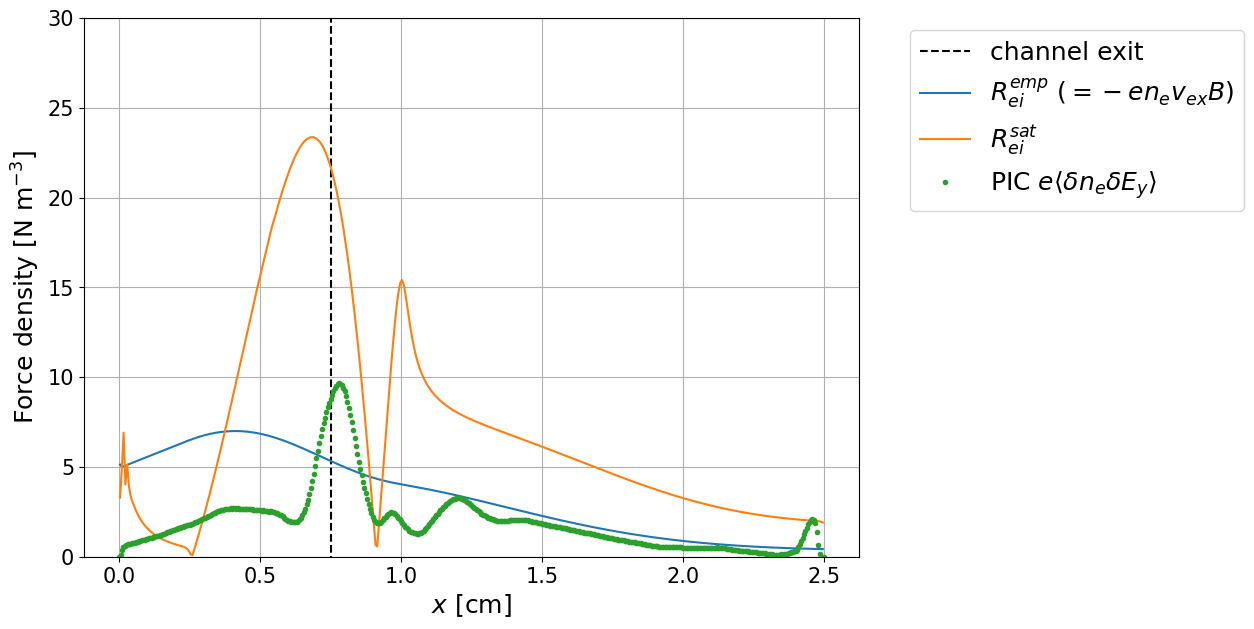

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, Rei_emp_arr, '-', label = "$R_{ei}^{emp}$ ($=-e n_e v_{ex} B$)")
ax.plot(x_center*100, Rei_sat_arr, '-', label="$R_{ei}^{sat}$")
ax.plot(extracted_df['x'], extracted_df['corr_term'], '.', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$")

ax.set_ylim([0., 30.])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Force density [N m$^{-3}$]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

## Comparison of energy terms

In [ ]:
mu_eff = FLHET_compiled.compute_mu(P, Barr, ESTAR, wall_inter_type, R1, R2, Mi, x_center, LTHR, KEL, alpha_B)

In [ ]:
E_acceleration_heating  = phy_const.e * P[1,:] * P[4,:]**2 / mu_eff     # e*n_e* vex^2 / mu
E_pressure_heating      = P[4, :] * np.gradient(phy_const.e * P[1, :] * P[3, :], x_center)
energy_inertia_term     = 2.5 * np.gradient(phy_const.e * P[1, :] * P[3, :] * P[4, :], x_center)

At steady-state the model of the 1D fluid code gives:
$$
\frac{5}{2}\partial_x (n_e k_B T_e v_{ex}) = e n_e v_{ex} \frac{v_{ex}}{\mu} + v_{ex} \partial_x (n_e k_B T_e)
$$
The left-hand side is an inertial term whereas the right-hand side got two source terms actually coming from the same physical cause. It is the work of the electric field (or power density given to the $e^-$ from the electric field):
$$
n_e q_e \mathbf{E} \cdot \mathbf{v_e} = e n_e v_{ex} \frac{v_{ex}}{\mu} + v_{ex} \partial_x (n_e k_B T_e)
$$
In the following, the curve right-hand side RHS is the sum of $e n_e v_{ex} \frac{v_{ex}}{\mu}$ and $v_{ex} \partial_x (n_e k_B T_e)$.

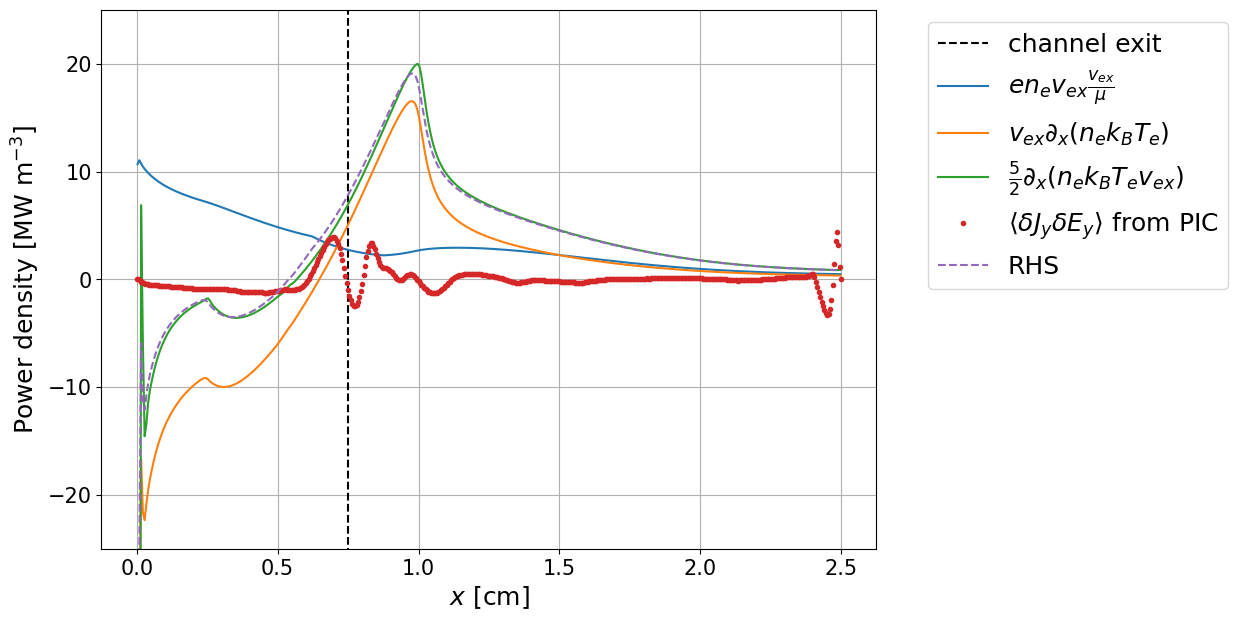

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, E_acceleration_heating/1e6, '-', label = "$e n_e v_{ex} \\frac{v_{ex}}{\\mu}$")
ax.plot(x_center*100, E_pressure_heating/1e6, '-', label = "$v_{ex} \\partial_x (n_e k_B T_e)$")
ax.plot(x_center*100, energy_inertia_term/1e6, '-', label = "$\\frac{5}{2}\\partial_x (n_e k_B T_e v_{ex})$")
ax.plot(extracted_df['x'], extracted_df['dJy_dEy']/1e6, '.', label="$\\langle \\delta J_y \\delta E_y \\rangle$ from PIC")
ax.plot(x_center*100, (E_acceleration_heating+E_pressure_heating)/1e6, '--', label = "RHS")

ax.set_ylim([-25., 25.])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Power density [MW m$^{-3}$]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

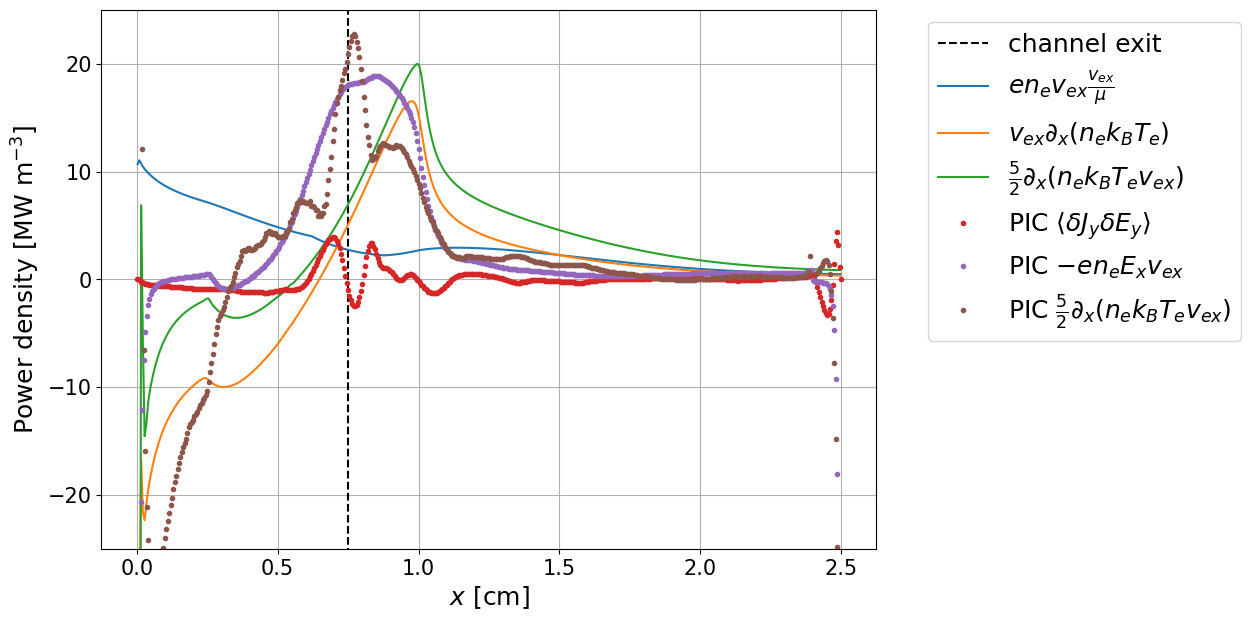

In [ ]:
PIC_E_heating = -phy_const.e * extracted_df['n_e'] * extracted_df['ve_x'] * extracted_df['EE']
PIC_inertia_term = 2.5 * np.gradient(phy_const.e * extracted_df['n_e'] * extracted_df['Te_y'] * extracted_df['ve_x'], extracted_df['x']/100)

f, ax = plt.subplots(figsize=(10,7))

ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, E_acceleration_heating/1e6, '-', label = "$e n_e v_{ex} \\frac{v_{ex}}{\\mu}$")
ax.plot(x_center*100, E_pressure_heating/1e6, '-', label = "$v_{ex} \\partial_x (n_e k_B T_e)$")
ax.plot(x_center*100, energy_inertia_term/1e6, '-', label = "$\\frac{5}{2}\\partial_x (n_e k_B T_e v_{ex})$")
ax.plot(extracted_df['x'], extracted_df['dJy_dEy']/1e6, '.', label="PIC $\\langle \\delta J_y \\delta E_y \\rangle$")
ax.plot(extracted_df['x'], PIC_E_heating/1e6, '.', label = "PIC $-e n_e E_x v_{ex}$")
ax.plot(extracted_df['x'], PIC_inertia_term/1e6, '.', label = "PIC $\\frac{5}{2}\\partial_x (n_e k_B T_e v_{ex})$")

ax.set_ylim([-25., 25.])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Power density [MW m$^{-3}$]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

Resultat bizarre pour le terme interiel venant de PIC donc zoom sur e facteur v_ex.

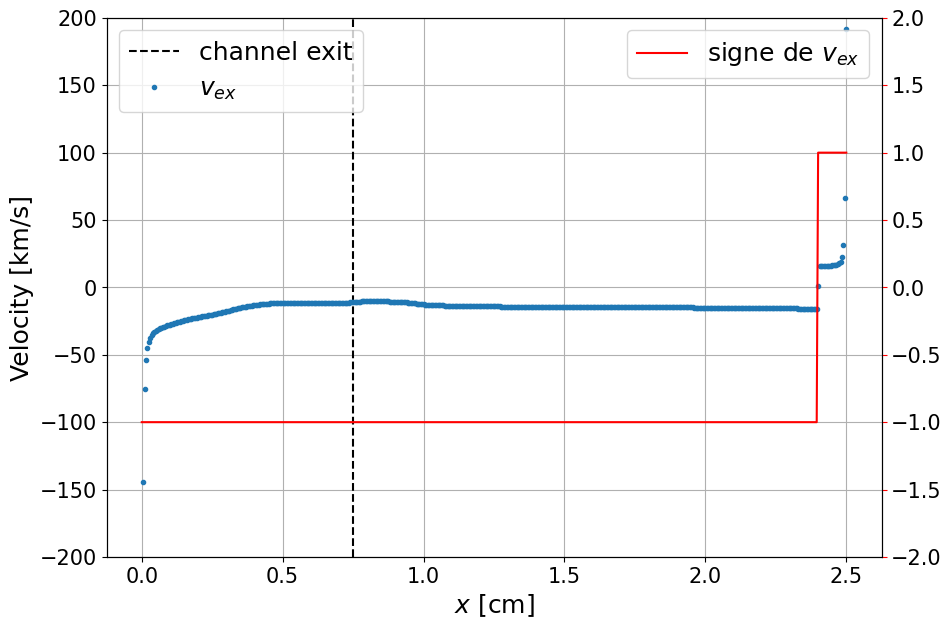

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax_b = ax.twinx()
ax.plot([LTHR*100, LTHR*100], [-200., 200.], 'k--', label = "channel exit")
ax.plot(extracted_df['x'], extracted_df['ve_x']/1e3, '.', label="$v_{ex}$")
ax.set_ylim([-200., 200.])
ax_b.plot(extracted_df['x'], np.sign(extracted_df['ve_x']), 'r-', label="signe de $v_{ex}$")
ax_b.set_ylim([-2, 2])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Velocity [km/s]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)
ax_b.yaxis.set_tick_params(labelsize=tickfontsize, color='r')

ax.grid()
ax.legend(loc="upper left", fontsize=legendfontsize)
ax_b.legend(loc='upper right', fontsize=legendfontsize)
plt.show()

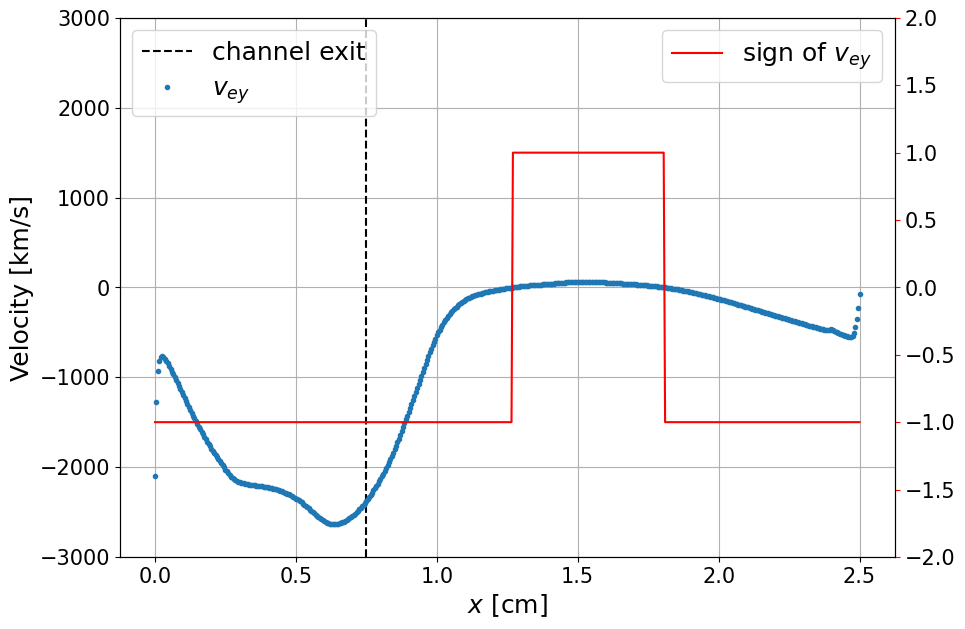

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax_b = ax.twinx()
ax.plot([LTHR*100, LTHR*100], [-3000., 3000.], 'k--', label = "channel exit")
ax.plot(extracted_df['x'], extracted_df['ve_y']/1e3, '.', label="$v_{ey}$")
ax.set_ylim([-3000., 3000.])
ax_b.plot(extracted_df['x'], np.sign(extracted_df['ve_y']), 'r-', label="sign of $v_{ey}$")
ax_b.set_ylim([-2, 2])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Velocity [km/s]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)
ax_b.yaxis.set_tick_params(labelsize=tickfontsize, color='r')

ax.grid()
ax.legend(loc="upper left", fontsize=legendfontsize)
ax_b.legend(loc='upper right', fontsize=legendfontsize)
plt.show()

## What $\nu_{anom}$ is needed to achieve the same friction force as $e\langle \delta n_e \delta E_y \rangle$

We want to find the anomalous freq. achieving the right frction force density:
$$
R_{ei}^{emp}(x) = e\langle \delta n_e \delta E_y \rangle
$$
$$
\Leftrightarrow -m_e v_{ey} n_e \nu_{anom} = e\langle \delta n_e \delta E_y \rangle
$$
$$
\Leftrightarrow \nu_{anom} = -\frac{e}{m_e}\frac{\langle \delta n_e \delta E_y \rangle}{v_{ey} n_e}
$$



Numerically, we would need a new equation in the fluid model that is:

$
\nu_{anom}^{n+1} = \frac{e}{m_e}\frac{\langle \delta n_e \delta E_y \rangle^{*}}{(-v_{ey}^n) n_e^n }
$

Where * means from PIC and constant during the fluid simlation.

### In terms of $\alpha_B$ (obsolete)

In [ ]:
function_corr_term = interpolate.interp1d(extracted_df['x'], extracted_df['corr_term']/(phy_const.e* (-extracted_df['ve_y']) * extracted_df['n_e']), bounds_error=False)
new_corr_term = function_corr_term(x_center*100)
RHS_alphaB = new_corr_term/Barr

In [ ]:
RHS_alphaB

array([ 1.82295500e-03,  6.12877831e-03,  7.71639785e-03,  7.62979875e-03,
        7.27124881e-03,  6.79251164e-03,  6.37590409e-03,  6.07714293e-03,
        5.82058526e-03,  5.58158076e-03,  5.37178941e-03,  5.28112340e-03,
        5.12119920e-03,  4.99336213e-03,  4.83024190e-03,  4.68435504e-03,
        4.56432596e-03,  4.45563950e-03,  4.29792266e-03,  4.17930925e-03,
        4.08985842e-03,  4.01571647e-03,  3.91113909e-03,  3.84545290e-03,
        3.80571607e-03,  3.74873184e-03,  3.69339122e-03,  3.65922092e-03,
        3.61161848e-03,  3.55439836e-03,  3.53277719e-03,  3.46055283e-03,
        3.43118211e-03,  3.40230844e-03,  3.33661333e-03,  3.30500131e-03,
        3.23891083e-03,  3.20015418e-03,  3.16329724e-03,  3.10251286e-03,
        3.06575211e-03,  3.01422031e-03,  3.01542404e-03,  2.98476150e-03,
        2.96581045e-03,  2.95691635e-03,  2.95104565e-03,  2.93370002e-03,
        2.90778060e-03,  2.89175975e-03,  2.87656564e-03,  2.85519338e-03,
        2.84313200e-03,  

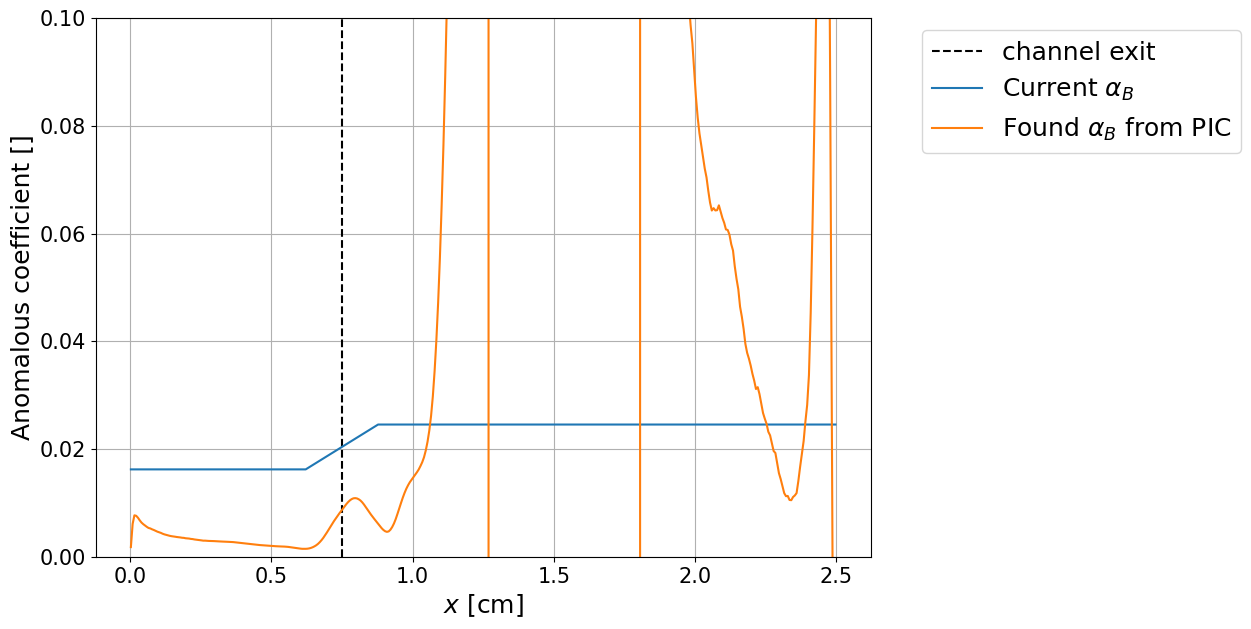

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot([LTHR*100, LTHR*100], [0., 1.], 'k--', label = "channel exit")
ax.plot(x_center*100, alpha_B, '-', label = "Current $\\alpha_B$")
ax.plot(x_center*100, RHS_alphaB, '-', label = "Found $\\alpha_B$ from PIC")

ax.set_ylim([0., 0.1])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous coefficient []", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

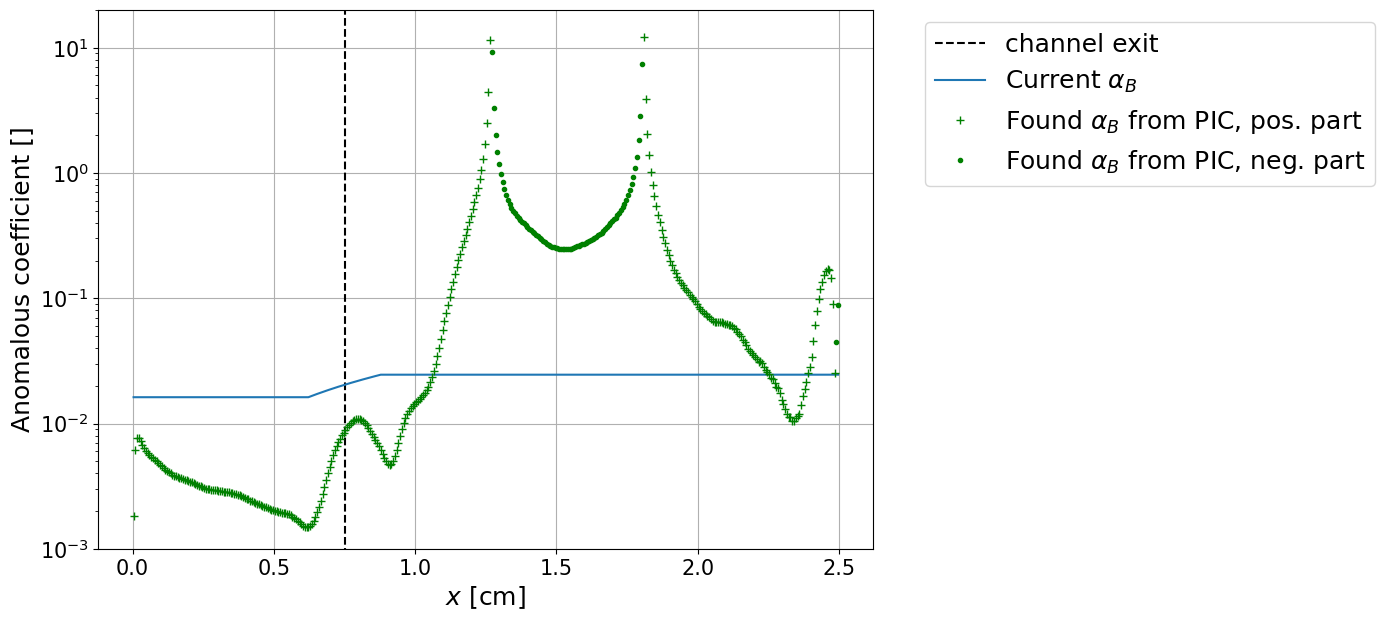

In [ ]:
RHS_alphaB_plus = RHS_alphaB[np.argwhere(RHS_alphaB > 0.)]
x_center_plus   = x_center[np.argwhere(RHS_alphaB > 0.)]

RHS_alphaB_minus = RHS_alphaB[np.argwhere(RHS_alphaB < 0.)]
x_center_minus   = x_center[np.argwhere(RHS_alphaB < 0.)]

f, ax = plt.subplots(figsize=(10,7))

ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, alpha_B, '-', label = "Current $\\alpha_B$")
ax.semilogy(x_center_plus*100, RHS_alphaB_plus, 'g+', label = "Found $\\alpha_B$ from PIC, pos. part")
ax.semilogy(x_center_minus*100, -RHS_alphaB_minus, 'g.', label = "Found $\\alpha_B$ from PIC, neg. part")
ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous coefficient []", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

### In terms of $\nu_{anom}$

In [ ]:
full_PIC_nu = (1/phy_const.m_e)*extracted_df['corr_term']/(- extracted_df['ve_y'] * extracted_df['n_e'])
full_PIC_nu = np.array(full_PIC_nu)
PIC_x       = np.array(extracted_df['x'])

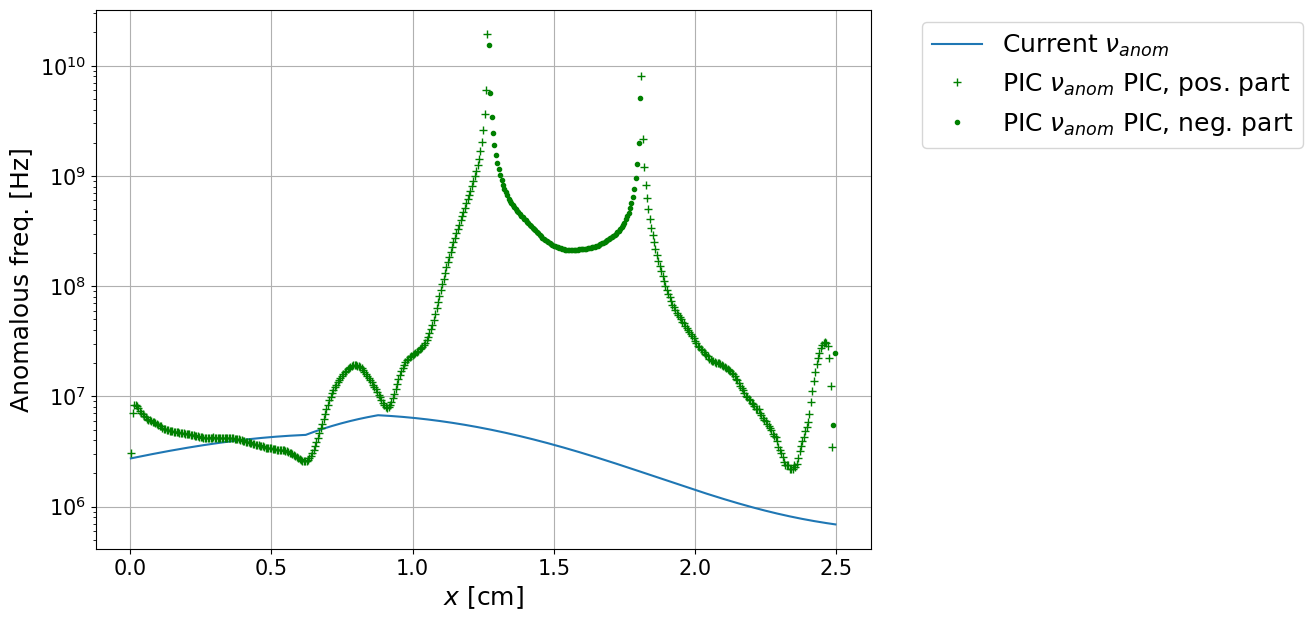

In [ ]:
current_nu  = alpha_B * (phy_const.e/(phy_const.m_e*2*np.pi)) * Barr

PIC_nu_plus = full_PIC_nu[np.argwhere(full_PIC_nu > 0.)]
PIC_x_plus   = PIC_x[np.argwhere(full_PIC_nu > 0.)]

PIC_nu_minus = full_PIC_nu[np.argwhere(full_PIC_nu < 0.)]
PIC_x_minus   = PIC_x[np.argwhere(full_PIC_nu < 0.)]

f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, current_nu, '-', label = "Current $\\nu_{anom}$")
ax.semilogy(PIC_x_plus, PIC_nu_plus, 'g+', label = "PIC $\\nu_{anom}$ PIC, pos. part")
ax.semilogy(PIC_x_minus, -PIC_nu_minus, 'g.', label = "PIC $\\nu_{anom}$ PIC, neg. part")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. [Hz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
# Saves this anomalous freq. to a .csv file
df_to_save_0 = pd.DataFrame({'x[cm]':PIC_x, 'nu_anom[Hz]':full_PIC_nu})
df_to_save_0.to_csv("./Inputs/nu_anom_arrays/full_PIC_nu.csv", sep='\t', float_format="%.6e")

In [ ]:
indices_boundary_positives = []
last_index_is_pos = (full_PIC_nu[0] > 0.)
foundEvenNumberOfPts = True
for i in range(1, full_PIC_nu.shape[0]):
    if full_PIC_nu[i] <= 0.:
        if last_index_is_pos:
            indices_boundary_positives.append(i-1)
            last_index_is_pos = False
            foundEvenNumberOfPts = not foundEvenNumberOfPts
    else:
        if not last_index_is_pos:
            indices_boundary_positives.append(i)
            last_index_is_pos = True
            foundEvenNumberOfPts = not foundEvenNumberOfPts

new_nu_1 = np.copy(full_PIC_nu)

if full_PIC_nu[0] <= 0.:
    first_i = indices_boundary_positives.pop(0)
    new_nu_1[0 : first_i] = full_PIC_nu[first_i]

if full_PIC_nu[-1] <= 0.:
    last_i = indices_boundary_positives.pop()
    new_nu_1[last_i+1:] = full_PIC_nu[last_i]     

if len(indices_boundary_positives) > 0:
    assert( len(indices_boundary_positives) % 2 == 0)
    while len(indices_boundary_positives) > 0:

        i2 = indices_boundary_positives.pop()
        i1 = indices_boundary_positives.pop()
        x2 = PIC_x[i2]
        x1 = PIC_x[i1]
        nu2 = full_PIC_nu[i2]
        nu1 = full_PIC_nu[i1]
        slope = (nu2 - nu1)/(x2 - x1)

        new_nu_1[i1:i2] = nu1 + (PIC_x[i1:i2] - x1)*slope

In [ ]:
corr_term_interp_f  = interpolate.interp1d(extracted_df['x']/100.0, extracted_df['corr_term'])
corr_term_interp    = corr_term_interp_f(x_center)
current_nu  = alpha_B * (phy_const.e/(phy_const.m_e*2*np.pi)) * Barr
hybrid_nu   = (corr_term_interp * alpha_B) / ( phy_const.m_e *(- P[4,:]) * P[1,:])
hybrid_nu   = np.where( hybrid_nu >= 0., hybrid_nu, 0.)

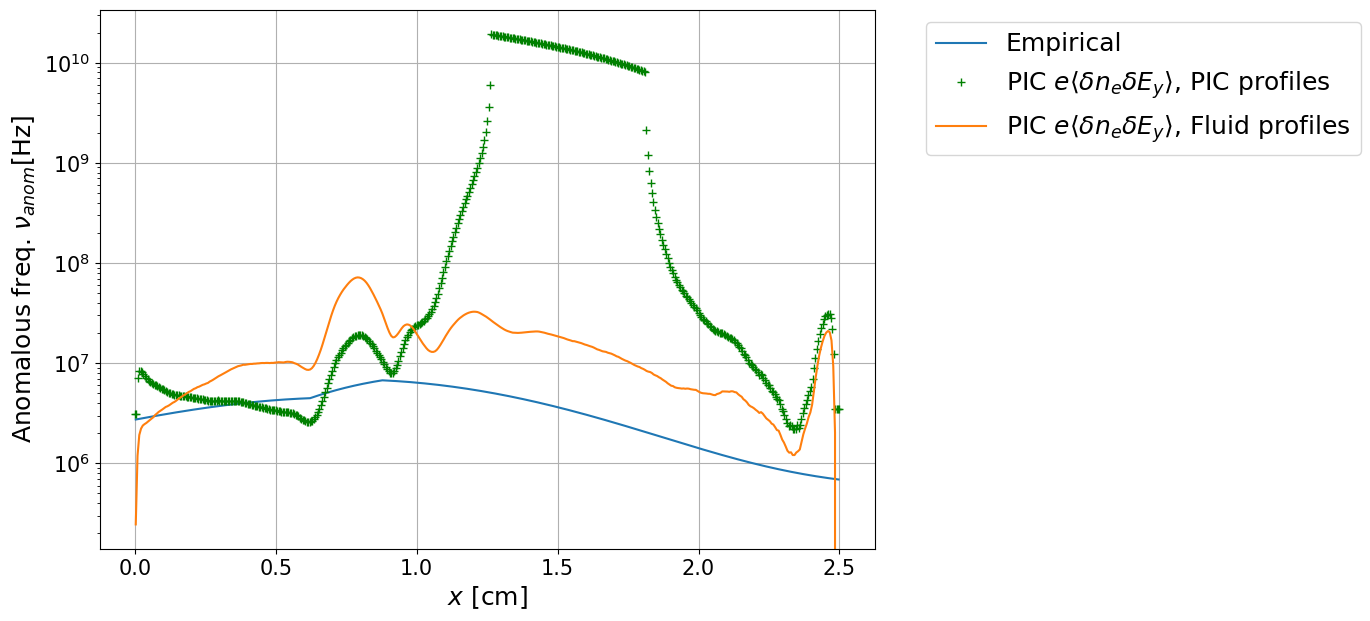

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, current_nu, '-', label = "Empirical")
ax.semilogy(PIC_x, new_nu_1, 'g+', label = "PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, PIC profiles")
ax.semilogy(x_center*100, hybrid_nu, '-', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, Fluid profiles")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. $\\nu_{anom}$[Hz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
current_Rei = Rei_emp_arr
hybrid_Rei  = - phy_const.m_e * (P[4,:]/alpha_B) * P[1,:] * hybrid_nu
azimuthal_flux_f    = interpolate.interp1d(extracted_df['ve_y'] * extracted_df['n_e'], extracted_df['x']/100)
azimuthal_flux      = azimuthal_flux_f(x_center)
full_PIC_Rei         = - phy_const.m_e * extracted_df['ve_y'] * extracted_df['n_e'] * new_nu_1

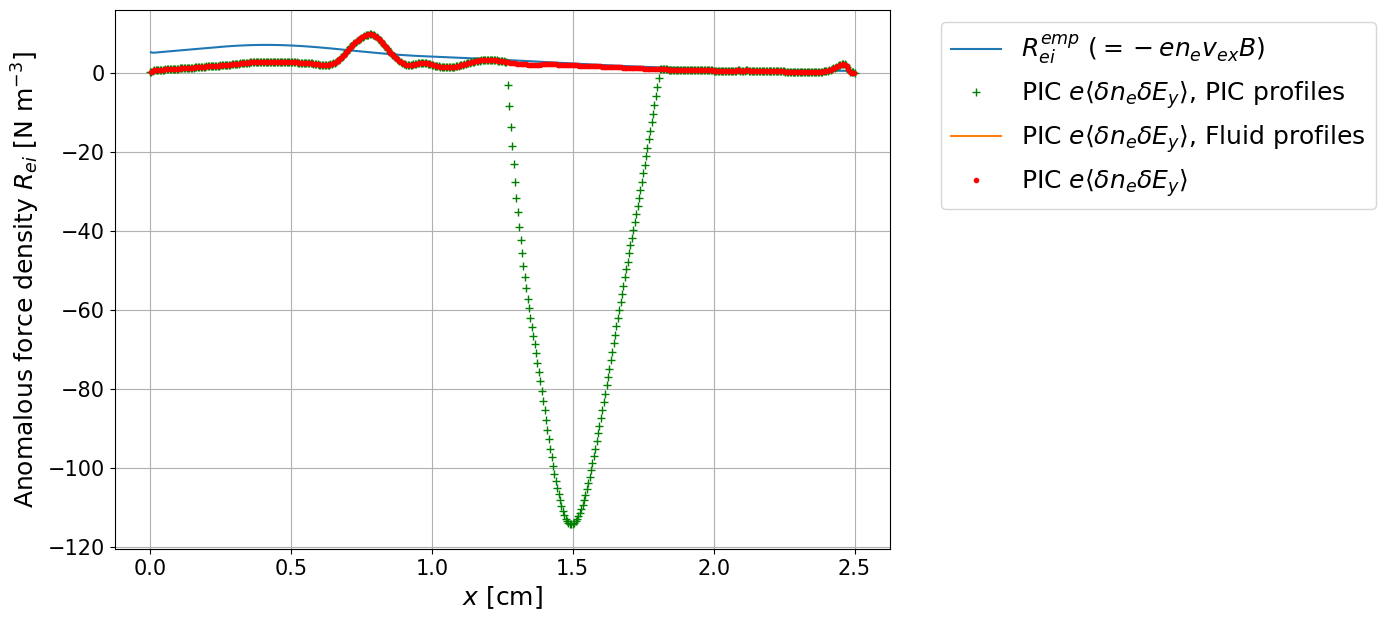

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, current_Rei, '-', label = "$R_{ei}^{emp}$ ($=-e n_e v_{ex} B$)")
ax.plot(extracted_df['x'], full_PIC_Rei, 'g+', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, PIC profiles")
ax.plot(x_center*100, hybrid_Rei, '-', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, Fluid profiles")
ax.plot(x_center*100, corr_term_interp, 'r.', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$")

#ax.set_ylim([0., 30.])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous force density $R_{ei}$ [N m$^{-3}$]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
df_to_save_1 = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':hybrid_nu})
df_to_save_1.to_csv("Inputs/nu_anom_arrays/nu_anom_extracted_1.csv", sep='\t', float_format="%.6e")

In [ ]:
full_PIC_nu_almost_pos  = np.where(full_PIC_nu > 0., full_PIC_nu, 1e-10)
interp_f    = interpolate.interp1d(extracted_df['x']/100, full_PIC_nu_almost_pos)
full_PIC_nu_almost_pos  = interp_f(x_center)
df_to_save_2    = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':full_PIC_nu_almost_pos})
df_to_save_2.to_csv("Inputs/nu_anom_arrays/nu_anom_extracted_2.csv", sep='\t', float_format="%.6e")

In [ ]:
abs_full_PIC_nu = np.abs(full_PIC_nu)
interp_f    = interpolate.interp1d(extracted_df['x']/100, abs_full_PIC_nu)
abs_full_PIC_nu  = interp_f(x_center)
df_to_save_3    = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':abs_full_PIC_nu})
df_to_save_3.to_csv("Inputs/nu_anom_arrays/abs_full_PIC_nu.csv", sep='\t', float_format="%.6e")

Drifts formulae:
$$
\mathbf{V_d} = \frac{1}{q}\frac{\mathbf{F} \times \mathbf{B}}{B^2}
$$

# Comparison of the heat flux from PIC and the fluid heat flux

## Extraction of the fluid data

In [2]:
fluid_dir   = "./Results/charoy_checkcase_0_N400_expl_hflux_no_coll_from_input"

unvariant_data_file     = fluid_dir + "/Data/MacroscopicUnvariants.pkl"
steady_stat_file        = fluid_dir + "/Data/MacroscopicVars_000087.pkl"

with open(unvariant_data_file, 'rb') as f:
    [Barr, x_mesh, x_center, alpha_B] = pickle.load(f)
Delta_x = x_mesh[1:] - x_mesh[:-1]
x_center_extended = np.insert(x_center, 0, -x_center[0])
x_center_extended = np.append(x_center_extended, x_center[-1] + Delta_x[-1])

with open(steady_stat_file, 'rb') as f:
    [t, P, U, P_LeftGhost, P_RightGhost, J, Efield] = pickle.load(f)

msp     = SimuParameters(fluid_dir + "/Configuration.cfg")

LTHR    = msp.LTHR
ESTAR   = msp.ESTAR
wall_inter_type     = msp.wall_inter_type
R1  = msp.R1
R2  = msp.R2
Mi  = msp.Mi
KEL = msp.KEL

NBPOINTS = np.shape(x_center)[0]

Default Magnetic Field
The ionization source term is imposed as specified in T.Charoy's thesis, section 2.2.2.


In [3]:
# computing the fluid heat flux
fluid_q = mplt_mod.compute_heat_flux(np.concatenate([P_LeftGhost, P, P_RightGhost], axis=1),  np.concatenate([[Barr[0]], Barr, [Barr[-1]]]), ESTAR, wall_inter_type, R1, R2, Mi, x_center_extended, LTHR, KEL, np.concatenate([[alpha_B[0]], alpha_B, [alpha_B[-1]]]))

## Extraction of the PIC dataframe

In [4]:
q_df = pd.read_csv("./Inputs/20240717_PIC_PAmadio/heat_flux_df.csv", sep='\t', header=0)

## Comparison with chart

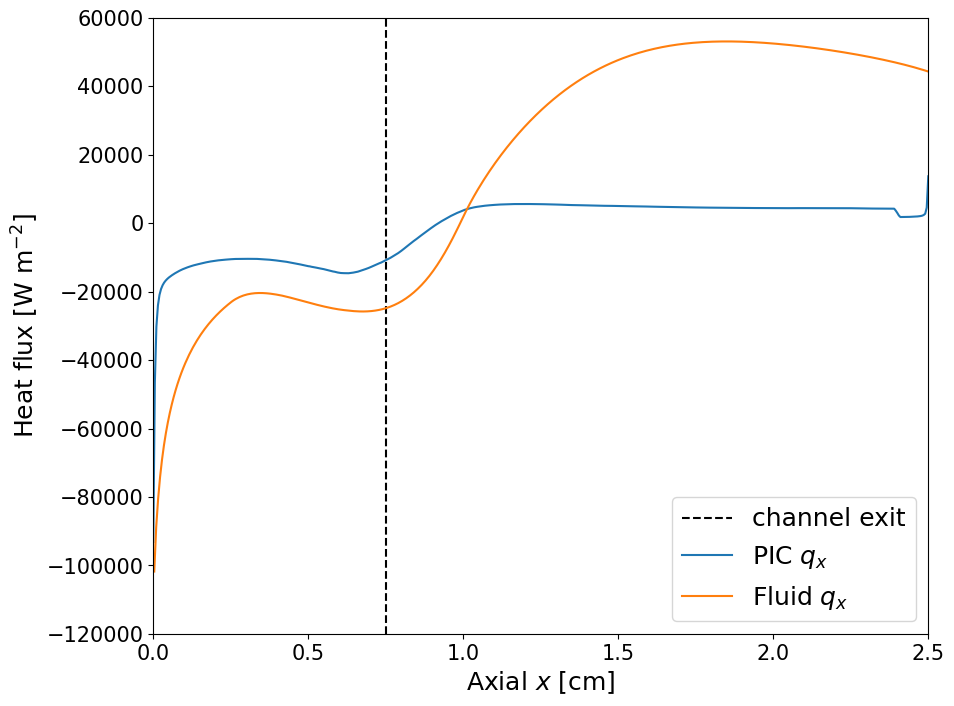

In [13]:
fig     = plt.figure(figsize=(10,8))
plt.plot([LTHR*100, LTHR*100],[-120000.0, 60000.0], 'k--', label="channel exit")
plt.plot(q_df['x[cm]'], q_df['q_x[W/m2]'], '-', label="PIC $q_x$")
plt.plot(x_center*100, fluid_q, '-', label="Fluid $q_x$")
plt.xlim([0., 2.5])
plt.ylim([-120000.0, 60000.0])
plt.xticks(fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.xlabel("Axial $x$ [cm]", fontsize=axisfontsize)
plt.ylabel("Heat flux [W m$^{-2}$]", fontsize=axisfontsize)
plt.legend(fontsize=legendfontsize)
plt.show()